# 03 — EDA Sanity Checks

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

ROOT = Path("/Users/chrisjuarez/CPSC483_ML_Project")

# Load processed data
X = pd.read_parquet(ROOT/"data/processed/features/table_v1.parquet")
y = pd.read_csv(ROOT/"data/processed/labels/labels_v1.csv")
spl = pd.read_csv(ROOT/"data/processed/splits/split_v1.csv")

# Merge all
df = X.merge(y, on="kepid").merge(spl, on="kepid")

FEATS = [c for c in X.columns if c != "kepid"]
TARGET = "label_lenient"

print("="*60)
print("DATA QUALITY CHECKS")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(FEATS)}")
print(f"Positive rate: {df[TARGET].mean():.4f}")

DATA QUALITY CHECKS
Dataset shape: (150762, 30)
Number of features: 23
Positive rate: 0.0241


CRITICAL CHECK: nquarters values
count    150762.000000
mean         16.270745
std           1.346839
min          10.000000
25%          16.000000
50%          17.000000
75%          17.000000
max          17.000000
Name: nquarters, dtype: float64
SUCCESS: nquarters has actual values!


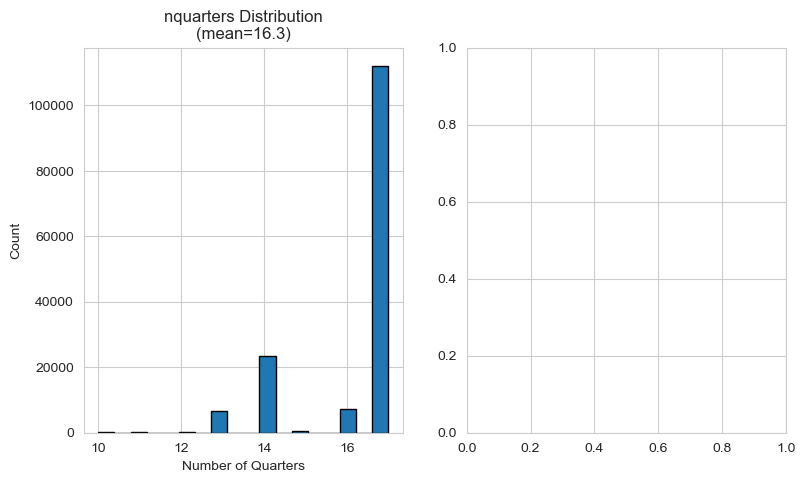

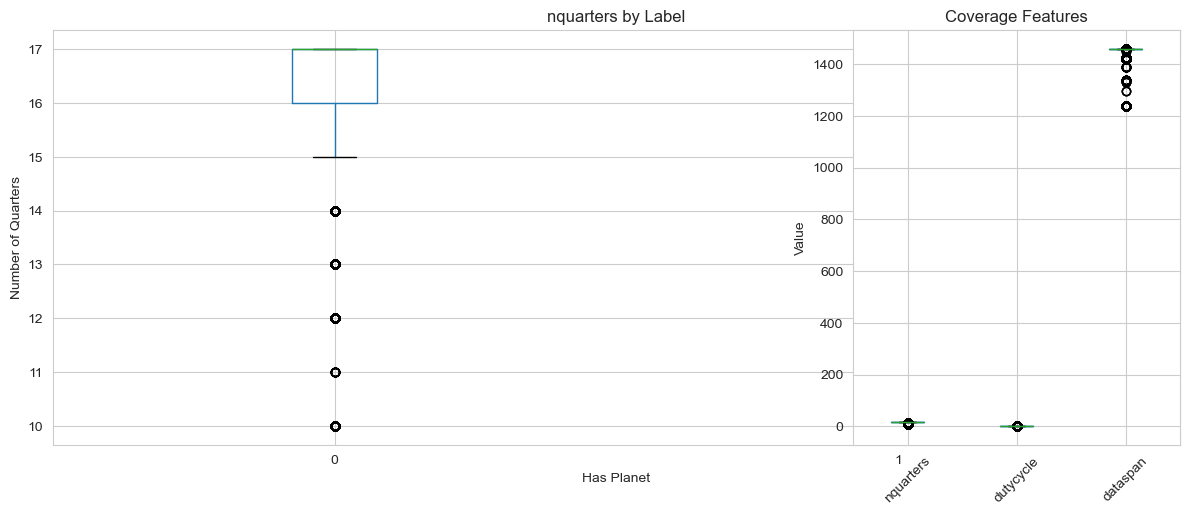

In [2]:
print("CRITICAL CHECK: nquarters values")
print("="*60)

# Check if nquarters is still broken (all zeros)
if "nquarters" in df.columns:
    nquarters_stats = df["nquarters"].describe()
    print(nquarters_stats)
    
    # Flag if still broken
    if df["nquarters"].max() == 0:
        print(" WARNING: nquarters is still all zeros! The fix didn't work.")
        print("Go back to 02_join_labels_clean and debug the count_ones function")
    else:
        print("SUCCESS: nquarters has actual values!")
        
    # Distribution plot
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 3, 1)
    df["nquarters"].hist(bins=18, edgecolor='black')
    plt.xlabel("Number of Quarters")
    plt.ylabel("Count")
    plt.title(f"nquarters Distribution\n(mean={df['nquarters'].mean():.1f})")
    
    plt.subplot(1, 3, 2)
    df.boxplot(column="nquarters", by="label_lenient")
    plt.xlabel("Has Planet")
    plt.ylabel("Number of Quarters")
    plt.title("nquarters by Label")
    plt.suptitle("")
    
    plt.subplot(1, 3, 3)
    coverage_cols = ["nquarters", "dutycycle", "dataspan"]
    if all(col in df.columns for col in coverage_cols):
        df[coverage_cols].boxplot()
        plt.ylabel("Value")
        plt.title("Coverage Features")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print(" ERROR: nquarters column not found!")

In [12]:
print("\nFEATURE INVENTORY CHECK")
print("="*60)

# Expected original features
original_features = [
    "teff", "logg", "feh", "radius", "mass", "kepmag",
    "rrmscdpp03p0", "rrmscdpp06p0", "rrmscdpp12p0",
    "dataspan", "dutycycle", "nquarters"
]

# Expected new features
expected_new = [
    "feh_x_teff", "radius_x_kepmag", "transit_prob", "stellar_density",
    "noise_star_ratio", "noise_consistency", "obs_quality", "detection_eff",
    "rrmscdpp03p0_log", "rrmscdpp06p0_log", "rrmscdpp12p0_log"
]

# Check what we actually have
found_original = [f for f in original_features if f in FEATS]
found_new = [f for f in expected_new if f in FEATS]
unexpected = [f for f in FEATS if f not in original_features + expected_new]

print(f"Original features found: {len(found_original)}/{len(original_features)}")
print(f"New engineered features found: {len(found_new)}/{len(expected_new)}")
print(f"Total features: {len(FEATS)}")

if len(found_original) < len(original_features):
    missing = set(original_features) - set(found_original)
    print(f" Missing original features: {missing}")

if len(found_new) < len(expected_new):
    missing_new = set(expected_new) - set(found_new)
    print(f" Missing engineered features: {missing_new}")
    
if unexpected:
    print(f" Additional features found: {unexpected[:5]}...")  # Show first 5

print("\n Feature engineering success!" if len(found_new) > 5 else "⚠️ Few engineered features found")


FEATURE INVENTORY CHECK
Original features found: 12/12
New engineered features found: 11/11
Total features: 23

 Feature engineering success!



 SPLIT STATISTICS
        count  n_positive  positive_rate  avg_quarters  avg_duty
split                                                           
test    30153         725         0.0240       16.2729    0.8362
train  105532        2540         0.0241       16.2691    0.8361
val     15077         363         0.0241       16.2777    0.8363


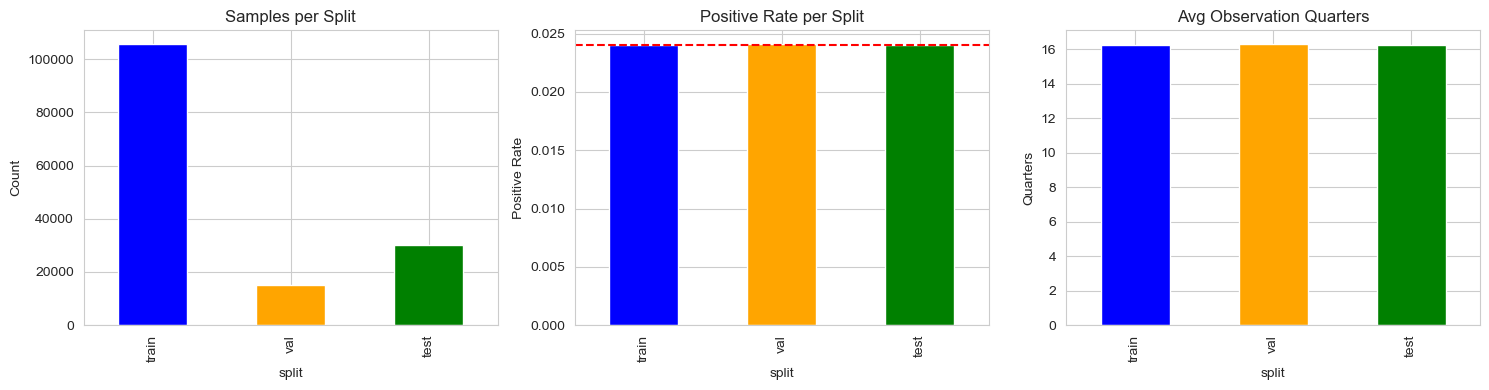

 Splits are well-balanced


In [13]:
print("\n SPLIT STATISTICS")
print("="*60)

# Detailed split analysis
split_analysis = df.groupby('split').agg({
    'kepid': 'count',
    TARGET: ['sum', 'mean'],
    'nquarters': 'mean',
    'dutycycle': 'mean'
}).round(4)

split_analysis.columns = ['count', 'n_positive', 'positive_rate', 'avg_quarters', 'avg_duty']
print(split_analysis)

# Visual check
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Split sizes
df['split'].value_counts().reindex(['train','val','test']).plot(
    kind='bar', ax=axes[0], color=['blue', 'orange', 'green']
)
axes[0].set_title("Samples per Split")
axes[0].set_ylabel("Count")

# Positive rates
df.groupby('split')[TARGET].mean().reindex(['train','val','test']).plot(
    kind='bar', ax=axes[1], color=['blue', 'orange', 'green']
)
axes[1].set_title(f"Positive Rate per Split")
axes[1].set_ylabel("Positive Rate")
axes[1].axhline(y=df[TARGET].mean(), color='red', linestyle='--', label='Overall')

# Coverage quality per split
if 'nquarters' in df.columns:
    df.groupby('split')['nquarters'].mean().reindex(['train','val','test']).plot(
        kind='bar', ax=axes[2], color=['blue', 'orange', 'green']
    )
    axes[2].set_title("Avg Observation Quarters")
    axes[2].set_ylabel("Quarters")

plt.tight_layout()
plt.show()

# Check if splits are balanced
rates = df.groupby('split')[TARGET].mean()
if rates.std() > 0.001:
    print(" Warning: Positive rates vary across splits - stratification may have issues")
else:
    print(" Splits are well-balanced")

In [14]:
print("\n MISSINGNESS ANALYSIS")
print("="*60)

miss = df[FEATS].isna().mean().sort_values(ascending=False)
miss_nonzero = miss[miss > 0]

if len(miss_nonzero) > 0:
    plt.figure(figsize=(10, max(4, len(miss_nonzero)*0.3)))
    miss_nonzero.plot(kind='barh')
    plt.xlabel("Missing Fraction")
    plt.title("Features with Missing Values")
    plt.tight_layout()
    plt.show()
    
    print(f"Features with missing values: {len(miss_nonzero)}")
    print(f"Max missingness: {miss_nonzero.max():.2%}")
else:
    print(" No missing values found (all were imputed)")


 MISSINGNESS ANALYSIS
 No missing values found (all were imputed)


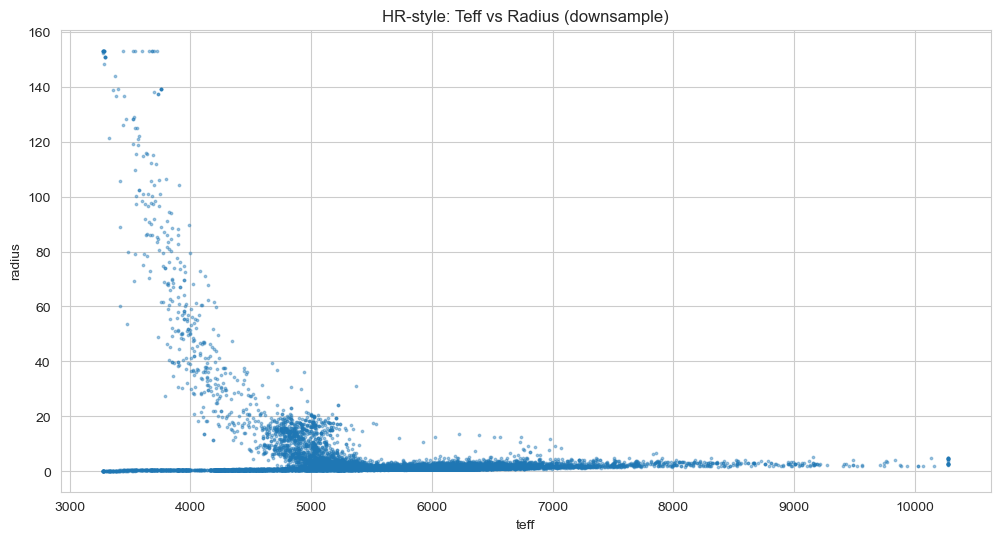

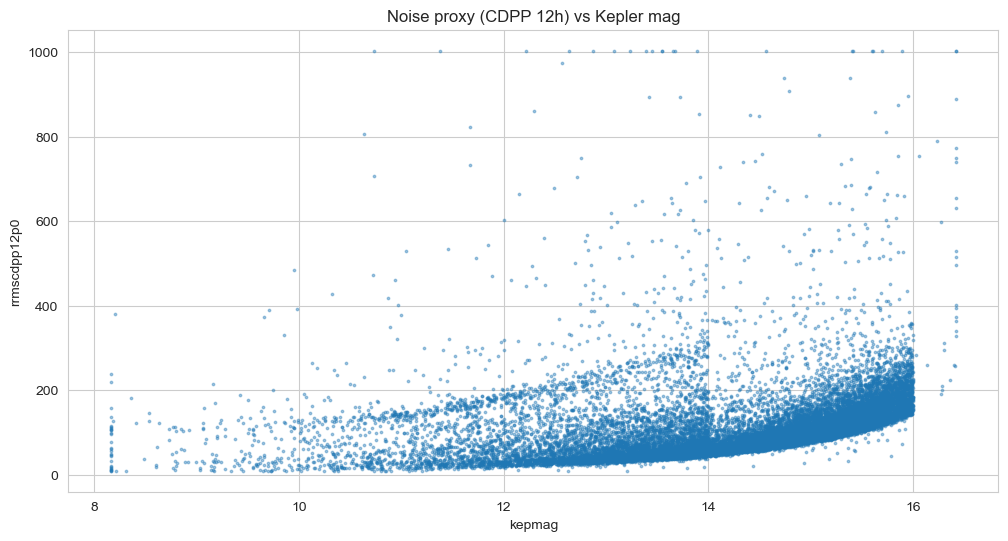

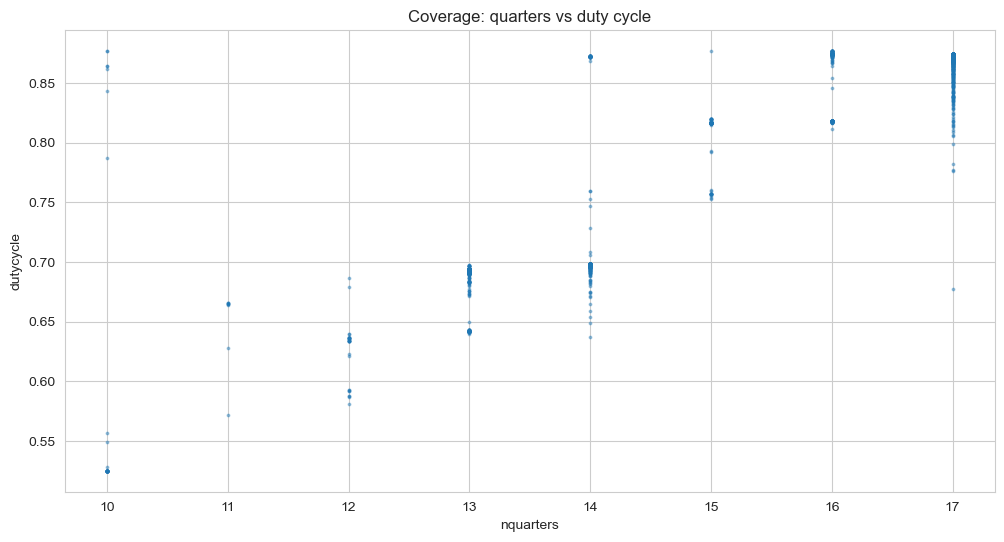

In [15]:
rng = np.random.default_rng(0)
sample = df.sample(20000, random_state=0) if len(df) > 20000 else df

def splot(x, y, ttl):
    plt.figure(); plt.scatter(sample[x], sample[y], s=3, alpha=0.4)
    plt.xlabel(x); plt.ylabel(y); plt.title(ttl); plt.show()

if {"teff","radius"}.issubset(df.columns):
    splot("teff","radius","HR-style: Teff vs Radius (downsample)")

if {"kepmag","rrmscdpp12p0"}.issubset(df.columns):
    splot("kepmag","rrmscdpp12p0","Noise proxy (CDPP 12h) vs Kepler mag")

if {"dutycycle","nquarters"}.issubset(df.columns):
    splot("nquarters","dutycycle","Coverage: quarters vs duty cycle")


 NEW FEATURE DISTRIBUTIONS


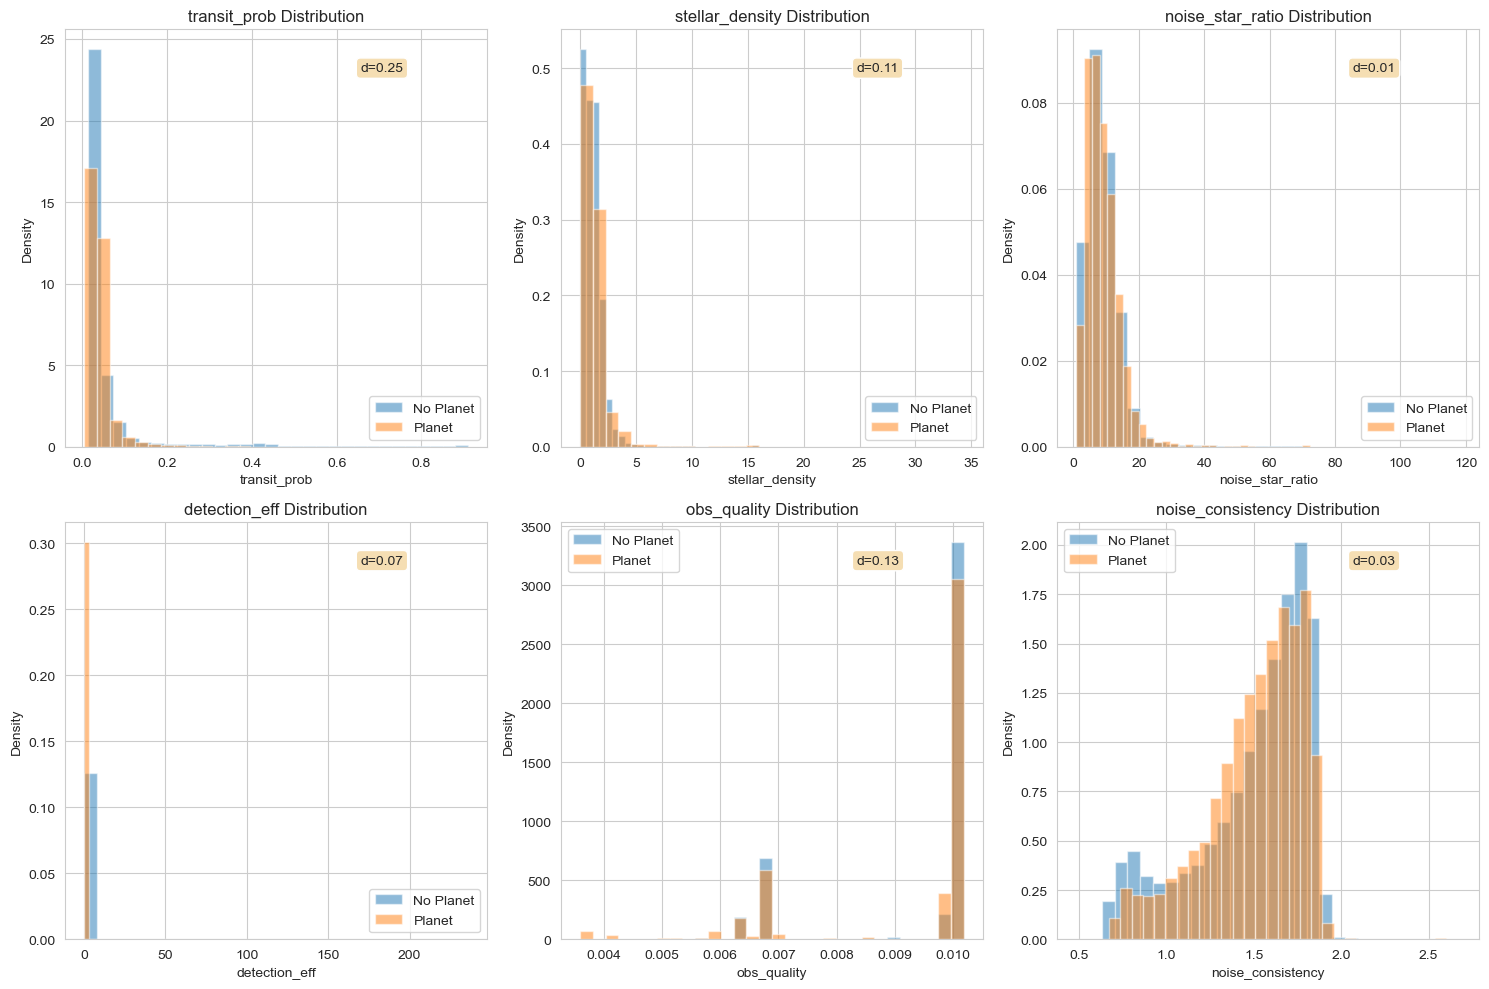

Plotted 6 engineered features


In [16]:
print("\n NEW FEATURE DISTRIBUTIONS")
print("="*60)

# Check key engineered features
new_features_to_plot = [
    "transit_prob", "stellar_density", "noise_star_ratio", 
    "detection_eff", "obs_quality", "noise_consistency"
]

available_new = [f for f in new_features_to_plot if f in df.columns]

if available_new:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feat in enumerate(available_new[:6]):
        ax = axes[idx]
        
        # Plot distribution by class
        for label in [0, 1]:
            data = df[df[TARGET] == label][feat].dropna()
            ax.hist(data, bins=30, alpha=0.5, label=f"{'Planet' if label else 'No Planet'}", 
                   density=True)
        
        ax.set_xlabel(feat)
        ax.set_ylabel("Density")
        ax.set_title(f"{feat} Distribution")
        ax.legend()
        
        # Add separation metric
        if df[df[TARGET]==1][feat].notna().any() and df[df[TARGET]==0][feat].notna().any():
            mean_diff = abs(df[df[TARGET]==1][feat].mean() - df[df[TARGET]==0][feat].mean())
            std_pool = np.sqrt((df[df[TARGET]==1][feat].var() + df[df[TARGET]==0][feat].var())/2)
            if std_pool > 0:
                cohen_d = mean_diff / std_pool
                ax.text(0.7, 0.9, f"d={cohen_d:.2f}", transform=ax.transAxes, 
                       bbox=dict(boxstyle="round", facecolor="wheat"))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {len(available_new)} engineered features")
else:
    print(" No engineered features found to plot")


 CDPP LOG TRANSFORM CHECK


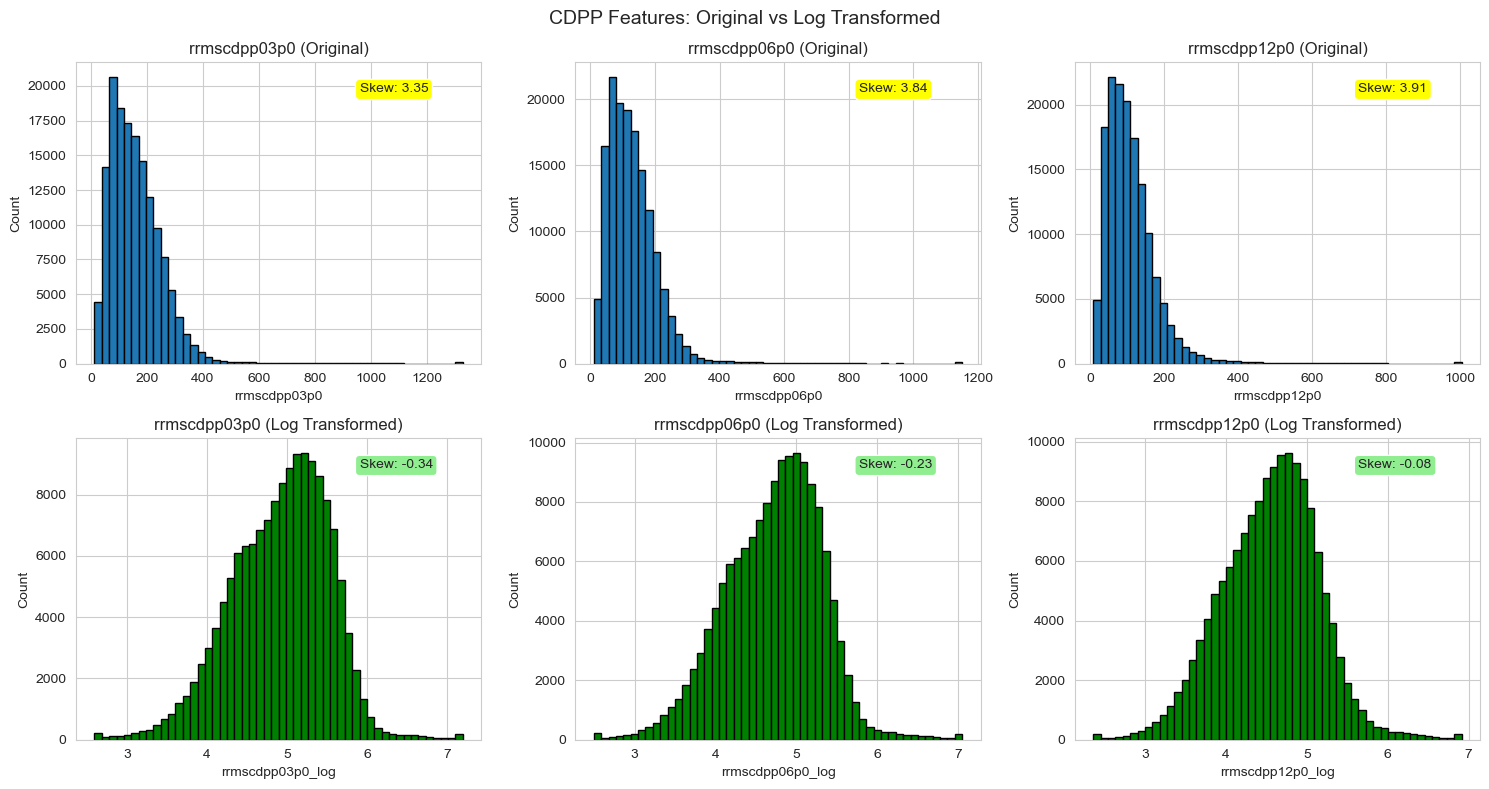

 rrmscdpp03p0: Skewness reduced from 3.35 to 0.34
 rrmscdpp06p0: Skewness reduced from 3.84 to 0.23
 rrmscdpp12p0: Skewness reduced from 3.91 to 0.08


In [17]:
print("\n CDPP LOG TRANSFORM CHECK")
print("="*60)

cdpp_cols = ["rrmscdpp03p0", "rrmscdpp06p0", "rrmscdpp12p0"]
cdpp_log_cols = [f"{c}_log" for c in cdpp_cols]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(cdpp_cols):
    if col in df.columns:
        # Original distribution
        ax = axes[0, idx]
        df[col].hist(bins=50, ax=ax, edgecolor='black')
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_title(f"{col} (Original)")
        ax.text(0.7, 0.9, f"Skew: {df[col].skew():.2f}", 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="yellow"))
        
        # Log transformed
        log_col = f"{col}_log"
        if log_col in df.columns:
            ax = axes[1, idx]
            df[log_col].hist(bins=50, ax=ax, edgecolor='black', color='green')
            ax.set_xlabel(log_col)
            ax.set_ylabel("Count")
            ax.set_title(f"{col} (Log Transformed)")
            ax.text(0.7, 0.9, f"Skew: {df[log_col].skew():.2f}", 
                    transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor="lightgreen"))

plt.suptitle("CDPP Features: Original vs Log Transformed", fontsize=14)
plt.tight_layout()
plt.show()

# Check if log transform helped
for col in cdpp_cols:
    if col in df.columns and f"{col}_log" in df.columns:
        orig_skew = abs(df[col].skew())
        log_skew = abs(df[f"{col}_log"].skew())
        if log_skew < orig_skew:
            print(f" {col}: Skewness reduced from {orig_skew:.2f} to {log_skew:.2f}")
        else:
            print(f" {col}: Skewness not improved")


🔗 FEATURE CORRELATION ANALYSIS
Highly correlated feature pairs (|r| > 0.8):
  logg <-> transit_prob: -0.942
  feh <-> feh_x_teff: 0.988
  radius <-> radius_x_kepmag: 0.992
  radius <-> transit_prob: 0.857
  rrmscdpp03p0 <-> rrmscdpp06p0: 0.972
  rrmscdpp03p0 <-> rrmscdpp12p0: 0.888
  rrmscdpp03p0 <-> noise_star_ratio: 0.934
  rrmscdpp03p0 <-> rrmscdpp03p0_log: 0.875
  rrmscdpp03p0 <-> rrmscdpp06p0_log: 0.868
  rrmscdpp03p0 <-> rrmscdpp12p0_log: 0.819


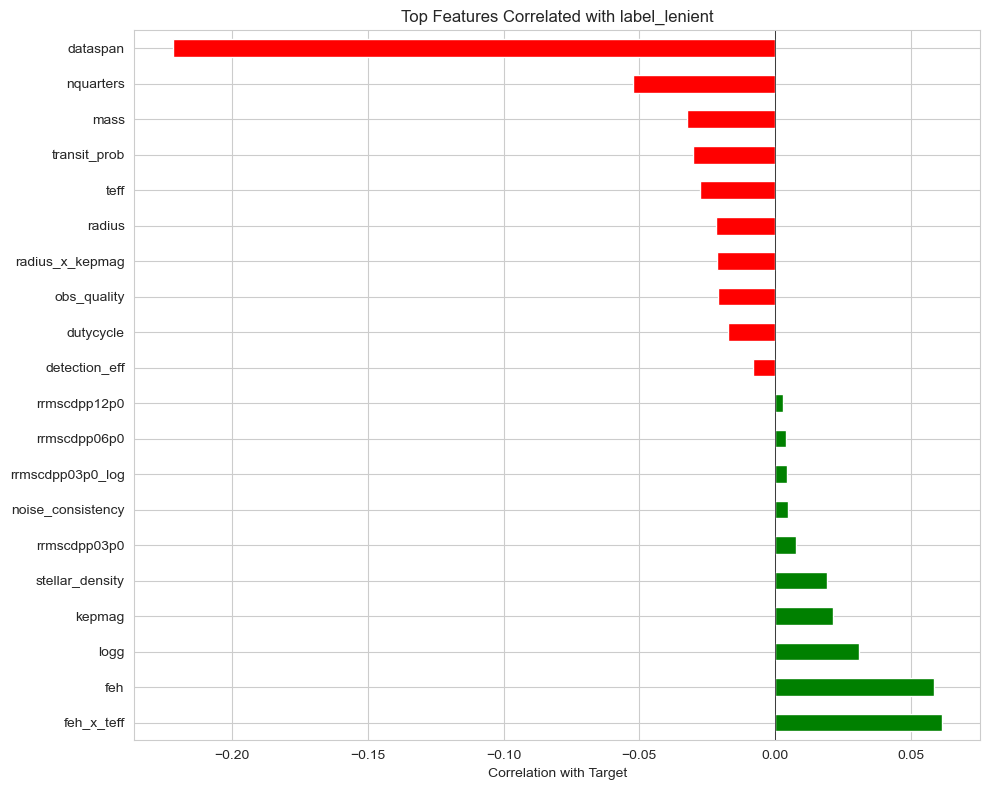


Top 5 positive correlations with label_lenient:
feh_x_teff         0.061337
feh                0.058682
logg               0.030757
kepmag             0.021288
stellar_density    0.019132
Name: label_lenient, dtype: float64

Top 5 negative correlations with label_lenient:
detection_eff     -0.007977
dutycycle         -0.017158
obs_quality       -0.021194
radius_x_kepmag   -0.021375
radius            -0.021636
Name: label_lenient, dtype: float64


In [18]:
print("\n🔗 FEATURE CORRELATION ANALYSIS")
print("="*60)

# Select numeric features
numeric_feats = df[FEATS].select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_feats) > 0:
    # Compute correlation matrix
    corr_matrix = df[numeric_feats].corr()
    
    # Find highly correlated pairs (excluding diagonal)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print("Highly correlated feature pairs (|r| > 0.8):")
        for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print(" No extremely high correlations found")
    
    # Correlation with target
    if TARGET in df.columns:
        target_corr = df[numeric_feats + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
        
        plt.figure(figsize=(10, 8))
        
        # Top positive correlations
        top_pos = target_corr.head(10)
        top_neg = target_corr.tail(10)
        top_features = pd.concat([top_pos, top_neg])
        
        top_features.plot(kind='barh', color=['green' if x > 0 else 'red' for x in top_features.values])
        plt.xlabel("Correlation with Target")
        plt.title(f"Top Features Correlated with {TARGET}")
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 5 positive correlations with {TARGET}:")
        print(top_pos.head(5))
        print(f"\nTop 5 negative correlations with {TARGET}:")
        print(top_neg.head(5))


📊 COVERAGE QUALITY ASSESSMENT


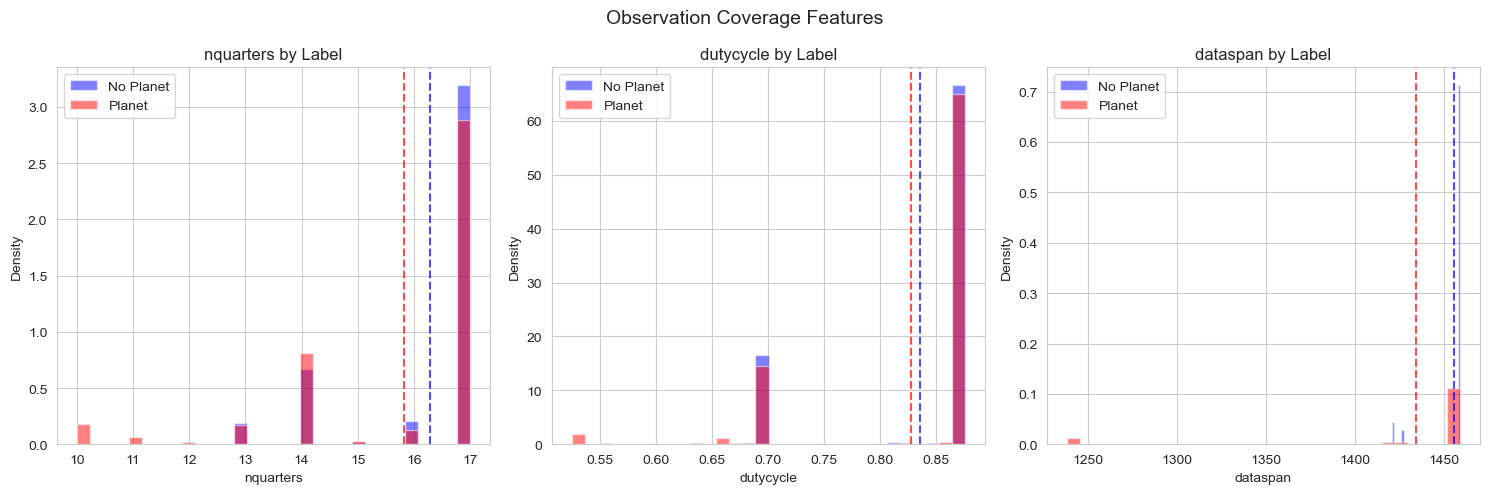


Coverage statistics by label:
              nquarters        dutycycle         dataspan        
                   mean    std      mean    std      mean     std
label_lenient                                                    
0                16.282  1.327     0.836  0.073  1455.617  10.472
1                15.823  1.931     0.828  0.087  1434.164  65.081

 Unexpected: Negatives have better coverage


In [19]:
print("\n📊 COVERAGE QUALITY ASSESSMENT")
print("="*60)

coverage_features = ["nquarters", "dutycycle", "dataspan"]
available_coverage = [f for f in coverage_features if f in df.columns]

if available_coverage:
    fig, axes = plt.subplots(1, len(available_coverage), figsize=(15, 5))
    if len(available_coverage) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(available_coverage):
        # Split by label
        no_planet = df[df[TARGET] == 0][feat].dropna()
        planet = df[df[TARGET] == 1][feat].dropna()
        
        axes[idx].hist(no_planet, bins=30, alpha=0.5, label="No Planet", color='blue', density=True)
        axes[idx].hist(planet, bins=30, alpha=0.5, label="Planet", color='red', density=True)
        axes[idx].set_xlabel(feat)
        axes[idx].set_ylabel("Density")
        axes[idx].set_title(f"{feat} by Label")
        axes[idx].legend()
        
        # Add statistics
        axes[idx].axvline(no_planet.mean(), color='blue', linestyle='--', alpha=0.7)
        axes[idx].axvline(planet.mean(), color='red', linestyle='--', alpha=0.7)
    
    plt.suptitle("Observation Coverage Features", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    coverage_stats = df.groupby(TARGET)[available_coverage].agg(['mean', 'std']).round(3)
    print("\nCoverage statistics by label:")
    print(coverage_stats)
    
    # Check if positives have better coverage (expected)
    if "nquarters" in df.columns:
        pos_quarters = df[df[TARGET] == 1]["nquarters"].mean()
        neg_quarters = df[df[TARGET] == 0]["nquarters"].mean()
        if pos_quarters > neg_quarters:
            print(f"\nPositives have better coverage ({pos_quarters:.1f} vs {neg_quarters:.1f} quarters)")
        else:
            print(f"\n Unexpected: Negatives have better coverage")

In [21]:
print("\n" + "="*60)
print("FINAL DATA QUALITY REPORT")
print("="*60)

# Compile all checks
checks = {
    "nquarters properly calculated": df["nquarters"].max() > 0 if "nquarters" in df.columns else False,
    "Engineered features created": len([f for f in expected_new if f in FEATS]) >= 5,
    "Log transforms applied": any("_log" in f for f in FEATS),
    "No missing values": df[FEATS].isna().sum().sum() == 0,
    "Balanced splits": df.groupby('split')[TARGET].mean().std() < 0.001,
    "Positive examples retained": df[TARGET].sum() > 1000,
    "Feature count > 20": len(FEATS) > 20,
    "Coverage filtering applied": df["nquarters"].mean() > 10 if "nquarters" in df.columns else False
}

print("Check Results:")
for check, passed in checks.items():
    status = "✅" if passed else "❌"
    print(f"  {status} {check}")

passed = sum(checks.values())
total = len(checks)
print(f"\nOverall: {passed}/{total} checks passed")

if passed == total:
    print("\n All checks passed! Data is ready for modeling.")
else:
    print(f"\n{total-passed} checks failed. Review the preprocessing pipeline.")

# Feature summary
print(f"\nFeature Summary:")
print(f"  Total features: {len(FEATS)}")
print(f"  Original features: {len([f for f in original_features if f in FEATS])}")
print(f"  Engineered features: {len([f for f in expected_new if f in FEATS])}")
print(f"  Dataset size: {len(df):,} samples")
print(f"  Positive rate: {df[TARGET].mean():.4f}")

# Save summary
summary_df = pd.DataFrame({
    'check': list(checks.keys()),
    'passed': list(checks.values())
})
summary_df.to_csv(ROOT/"data/processed/eda_checks.csv", index=False)
print(f"\n Saved check results to data/processed/eda_checks.csv")


FINAL DATA QUALITY REPORT
Check Results:
  ✅ nquarters properly calculated
  ✅ Engineered features created
  ✅ Log transforms applied
  ✅ No missing values
  ✅ Balanced splits
  ✅ Positive examples retained
  ✅ Feature count > 20
  ✅ Coverage filtering applied

Overall: 8/8 checks passed

 All checks passed! Data is ready for modeling.

Feature Summary:
  Total features: 23
  Original features: 12
  Engineered features: 11
  Dataset size: 150,762 samples
  Positive rate: 0.0241

 Saved check results to data/processed/eda_checks.csv
